# Deep learning in biomedicine, CS-502
## HW02, Marija Zelic, SCIPER 371272

Purpose of this homeowork is to build and compare different GNN models to implement graph classification. The dataset that is used is MUTAG dataset that containes 188 small graphs that represent nitroaromatic molecules, some of which have mutagenetic effect on bacteria *Salmonella typhimurium'* (class 1) and some not (class 0). Our first task is to obtain the data set and load it to the notebook.

## 1. Dataloader for MUTAG dataset  

Data can be loaded directly using datasets library.

In [1064]:
import huggingface_hub

from datasets import load_dataset
from datasets import Dataset

from scipy import sparse as sp
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import networkx as nx

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # because of nx.adjacency_matrix

dataset = load_dataset("graphs-datasets/MUTAG",split="train", download_mode='force_redownload')  

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/188 [00:00<?, ? examples/s]

Dataset json downloaded and prepared to /Users/marijazelic/.cache/huggingface/datasets/graphs-datasets___json/graphs-datasets--MUTAG-a0cf78a2615b5c11/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


Each element in *dataset* variable contains:  
* **node_features** - list of shape (#nodes, #node_features), containing initial node embeddings
* **edge_index** - list of shape (2, #edges), containing all of the edges between the nodes
* **edge_attr** - list of shape (#edges, #edge_features), containing edge features
* **y** - label 0 or 1 for classifying each molecule
* **num_nodes** - number of nodes that graph (molecule) has  

Let's visualise one of the graphs (molecules) so that would be easier for us to percieve it. We need to convert it to *networkx* type Graph so we can use its functions for plotting graphs.  
As we are going to use PyTorch library, it would be more conveniet for us to convert all of the data to *torch* type.

In [1065]:
dataset.set_format(type='torch', columns=['edge_index', 'node_feat', 'edge_attr', 'y', 'num_nodes'])

We can output the *y* parameter that represents class label for each of the graphs in the dataset. This can be useful because we can see how many samples belong to the one or the other class, i.e. whether classes are balanced or not. Deriving this conclusion will give us an important insight into structure of the dataset, which can help us for making better network arhitecture for classification.  

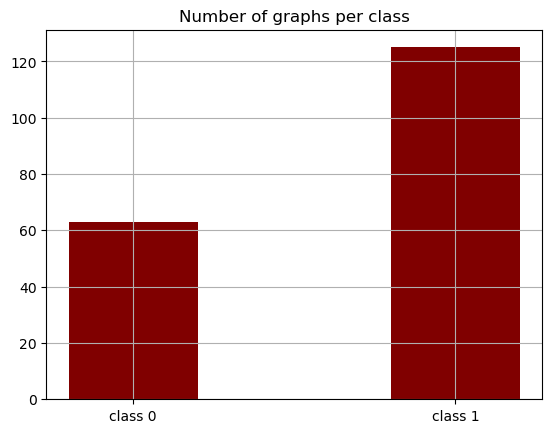

Class 0: 63
Class 1: 125


In [1066]:
classes = dataset['y'].squeeze(-1)

# It's more convenient to just count the number of graphs per class
# We will make torch.zeros tensor of the same length as the dataset and compare elements to determine number of graphs per
comparison0 = torch.zeros(len(dataset), dtype=int)
comparison1 = torch.ones(len(dataset), dtype=int)

class_0 = torch.eq(classes, comparison0)
class_1 = torch.eq(classes, comparison1)

num_class_0 = class_0.sum()
num_class_1 = class_1.sum()

# Bar to compare number of graphs per class
names = ['class 0', 'class 1']
numbers = [num_class_0, num_class_1]
fig = plt.figure()
plt.bar(names, numbers, color ='maroon', width = 0.4)
plt.title("Number of graphs per class")
plt.grid(visible=True)
plt.savefig("classes.png")
plt.show()

print(f"Class 0: {num_class_0:d}")
print(f"Class 1: {num_class_1:d}")

From the previous plot we can conclude that classes are imbalanced as class labeled with 1 has almost twice as much graphs as the class 0. This will lead to the problems with classification as the learning algorithm will have better generalization for the graphs in the class 1. We have a couple of ways we can deal with such an issue, but we will focus more on that when we reach the point of an actual model training.

It will be very convenient for the later to implement the function that uses the provided data to convert the graph into an *nx.Graph* object.

In [1067]:
def convert_to_graph(dataset_element):
    """ 
    Converts dataset element to graph.
    
    Args: 
        dataset_element (dict): one graph with params node_feat, edge_index, edge_feat
        
    Returns:
        graph (nx.graph): element of dataset converted to the graph
        
    """
    graph = nx.Graph()
    
    # We extract the information about the number of nodes 
    num_nodes = dataset_element['node_feat'].squeeze(0).size(dim=0)
    nodes = np.arange(num_nodes)
    nodes = nodes.tolist()
    
    # Add the nodes to the graph
    graph.add_nodes_from(nodes)
    
    # Add the edges to the graph
    edge_list = dataset_element['edge_index'].squeeze(0).tolist()
    new_edge_list = []
    dim = len(edge_list[0])
    
    for i in range(dim):
        new_edge_list.append([edge_list[0][i], edge_list[1][i]])

    graph.add_edges_from(new_edge_list)
    return graph 

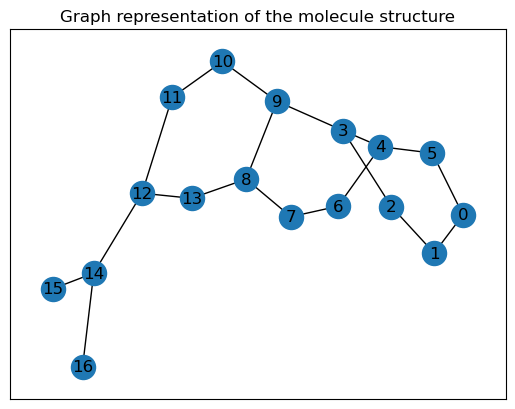

In [1068]:
# Load first element of dataset to graph.
graph = convert_to_graph(dataset[0])

# Vizualizing the graph (molecule).
fig, ax = plt.subplots(1, 1)
ax.set_title('Graph representation of the molecule structure')
nx.draw_networkx(graph)
plt.savefig("molecul.png")

Only feature we are missing for every graph is adjacency matrix. We can directly obtain it using the function adjacency_matrix from networkx library. In order for it to become a tensor, we will make custom function.

In [1069]:
# Function for obtaining and converting adjacency matrix to tensor
def adj_matrix_totensor(graph):
    """ 
    Function for obtaining and converting adjacency matrix to tensor.
    
    Args:
        graph (nx.Graph): graph for which we want get adjacency matrix
        
    Returns:
        torch.sparse_coo_tensor: adjacency_matrix
    """ 
    
    adj = nx.adjacency_matrix(graph)
    adj = sp.coo_array(adj)
    
    return torch.sparse_coo_tensor(
        torch.LongTensor(np.vstack((adj.row, adj.col))),
        torch.FloatTensor(adj.data),
        torch.Size(adj.shape))

## 2. Implementing different Graph Convolution and Pooling layers
### 2.1. Normal Convolution (Graph Convolution)  
The normal convolution layer aggregates neighbor data without any specific attention mechanism. The equation for normal convolution layer in matrix form can be written as:  
$$
H^{(l+1)} = \sigma\left( \tilde{A}H^{(l)}W_l^\top + H^{(l)}B_l^\top \right)
$$  where $\tilde{A}$ is a diagonal matrix containing inverse of the degree and $\mathbf{W}$ and $\mathbf{B}$ are trainable weight matrices of the layer.

In [1070]:
# First we implement basic Graph Convolution Layer
class GraphConv(nn.Module):
    """ Normal Convolution layer implementing simple neighbor aggregation. """
    
    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the graph convolution layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        
        super().__init__()
        self.activation = activation
        
        # Learnable weight matrices using linear layers
        self.weight = nn.Linear(in_features, out_features, bias=False)
        nn.init.xavier_uniform_(self.weight.weight)
        
        self.bias = nn.Linear(in_features, out_features, bias=False)
    
    def forward(self, x, adj):
        """
        Aggregate the neighbours' node embeddings.
        
        Args:
            x (list of tesor): list of mini batch input node embeddings of shape of each (num_nodes, in_features)
            adj (list of tensor): list of mini batch sparse adjacency matrix of the graph of shape of each (num_nodes, num_nodes)
        
        Returns:
            list of tensors: list of mini batch output node embeddings after aggregation, shape of each (num_nodes, out_features)
        """
        
        # First we form A_tilde matrix, assuming that there is no nodes without neighbors within a graph
        adj = adj / adj.sum(1, keepdims=True).clamp(min=1)
        
        # Then we aggregate all the neighbours
        x_agg = torch.matmul(adj, x)
        
        # Now we perform matrix multiplication with learnable weight matrices
        x = self.weight(x_agg) + self.bias(x)
        
        # Applying selected activation function
        if self.activation is not None:
            x = self.activation(x)
            
        return x

### 2.2. GraphSAGE (Customized Aggregation)  
The equation for the GraphSAGE layer is:
$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \cdot \mathrm{CONCAT} \left[\mathbf{h}_v^{(l)}, \mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) \right] \right),
$$
where $v$ index the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ is the trainable weight matrix of the layer. $\mathrm{CONCAT}$ is the concatenation operation, while $\mathrm{AGG}$ is an arbitrary aggregation function.

In [1071]:
class GraphSAGEConv(nn.Module):
    """ GraphSAGE convolutional layer. """
    
    def __init__(self, in_features, out_features, aggregation, activation=None):
        """
        Initialize the GraphSAGE convolutional layer.
        
        Args:
            in_features (int): number of input node features
            out_features (int): number of output node features
            aggregation (MeanAggregation or se other aggregation classes below): aggregation function to apply, as x_agg = aggegration(x, adj).
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.aggregation = aggregation
        self.activation = activation
        
        # One learnable weight matrix using the linear layer
        self.weight = nn.Linear(in_features * 2, out_features, bias=False)
        nn.init.xavier_uniform_(self.weight.weight)
        
    def forward(self, x, adj):
        """
        Perform graph convolution operation.
        
        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).
        
        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # First we aggregate neighbours'node embeddings, shape stays the same (num_nodes, in_features)
        x_agg = self.aggregation(x, adj)
        
        # Concatanate node features with its neighbouring ones, shape is now (num_nodes, 2*in_features)
        concatenation = torch.cat([x, x_agg], dim=-1)
        
        # Apply linear layer, shape is (num_nodes, out_features)
        x = self.weight(concatenation)
        
        # apply activation function
        if self.activation is not None:
            x = self.activation(x)

        return x

#### 2.2.1. Aggregation functions for GraphSAGE layer  
We need to provide different options for GraphSAGE aggregation functions, so they will be implementented on the side. Implemented aggregation functions will be: Mean (as in Normal Convolution layer), Max Pool and SqrtDegAggregation. SqrtDegAggregation is defined by the formula:
$$\mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) = \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{\sqrt{\mathrm{deg}(v)}\sqrt{\mathrm{deg}(u)}},$$

In [1072]:
class MeanAggregation(nn.Module):
    """ Aggregate node features by averaging over the neighbourhood. """
    def __init__(self):
        super().__init__()
    
    def forward(self, x, adj):
        
        adj = adj / adj.sum(1, keepdims=True)
        x_agg = torch.matmul(adj, x)
        
        return x_agg

In [1073]:
class MaxPoolAggregation(nn.Module):
    """ Aggregate node features by taking the maxiumum over the transformed neighbourhood. """
    def __init__(self):
        super().__init__()
        
    def forward(self, x, adj):
        num_samples = x.size(dim=0)
        in_features = x.size(dim=1)
        x_agg = torch.zeros(num_samples, in_features)
        
        for i in range(num_samples):
            # For every node we find indexes od its neighbours
            neighbours_index = torch.nonzero(adj[i]).squeeze(-1)
            neighbours = torch.index_select(x, 0, neighbours_index)
            
            # We max pool features of all neighbours
            x_agg[i], indices = torch.max(neighbours, dim=0)
            
        return x_agg

In [1074]:
class SqrtDegAggregation(nn.Module):
    """ Aggregate node features by summing over the neighborhood and normalizing by the degrees. """
    def __init__(self):
        super().__init__()
    
    def forward(self, x, adj):
        # First, same part as in the MeanAggregation
        adj = adj / torch.sqrt(adj.sum(1, keepdims=True))
        
        #Multiply every node embedding with its degˆ{-1}
        x = x / torch.sqrt(adj.sum(1, keepdims=True))
        x_agg = torch.matmul(adj, x)
        
        return x_agg 

### 2.3. Attention-based Convolution  
Attention-based Convolution applies attention mechanism to neighbor aggregation. The equation for Attention-based Convolution at layer *l* can be defined as follows: 
$$\mathbf{h}_v^{'(l)}=\mathbf{W}_l\mathbf{h}_v^{(l)}$$  
$$\mathbf{h}_v^{(l+1)}=\sigma\left(\sum_{u \in N(v) \cup \{v\}}a_{vu}^{(l)} \cdot \mathbf{h}_{u}^{'(l)}\right)$$  
where $a_{vu}^{(l)}$ is normalized attention weights between node node $v$ and its neighbour node $u$ as well as itself. Below you can find formula to compute attention weights. $N(v) \cup \{v\}$ is the union of the neighbours of node $v$ and itself.  
The attention score $e_{vu}$ between node $v$ and its neighbour $v$ is calculated as the dot product between a learnable weight vector and concatenation of their features and passed through a LeakyReLU activation:
$$e_{vu}=LeakyRELU\left(\mathbf{S}^T \cdot CONCAT \left(\mathbf{h}_{v}^{'(l)}, \mathbf{h}_{u}^{'(l)}\right)\right),$$
where $\mathbf{S}$ is a learnable weight vector, shared amongst all nodes. Note that this attention score is applied to the transformed node embeddings.  
After calculating the attention scores, we apply the softmax function to obtain normalized attention weights. These weights represent the importance of each neighbour node in relation to node $v$:
$$a_{vu}=\frac{exp\left(e_{vu}\right)}{\sum_{k \in N(v) \cup \{v\}}exp\left(e_{vk}\right)}.$$

In [1075]:
class AttentionConv(nn.Module):
    """ Attention-based convolution layer. """
    
    def __init__(self, in_features, out_features, activation=None):
        """ Initialize Attention-based convolution layer.
        
            Args: 
                in_features (int) : number of node's input features
                out_features (int): number of nodes' output features
                activation (nn.Module or callable): activation function to be applied at the end
        """
        super().__init__()
        # Initialize two linear layers for learnable weights
        self.weight = nn.Linear(in_features, out_features, bias=False) # All nodes transformation
        nn.init.xavier_uniform_(self.weight.weight)
        
        self.attention_score = nn.Linear(2 * out_features, 1, bias=False) # Weights for calculating attention score
        nn.init.xavier_uniform_(self.attention_score.weight)
        
        # Initialize activation function
        self.activation = activation
        
    def forward(self, x, adj):
        """ Aggregate node emeddings using attention-based mechanism. 
            
            Args:
                x (tensor): contains all node's embeddings, shape (num_nodes, in_features)
                adj (tensor): adjacency matrix of the graph, shape (num_nodes, num_nodes)
            
            Returns:
                (tensor): node's features after attention-based aggregation, shape (num_nodes, out_features)
            
        """
        num_nodes = x.size(dim=0)
        
        # First, apply linear transformation to every node's embedding
        x = self.weight(x) # new shape is (num_nodes, out_features)
        
        # Because in every calculation root node is included, we will add I matrix to adj
        adj = adj + torch.eye(num_nodes)
        
        x_agg = []
        # Updating each node embedding
        for i in range(num_nodes):
            
            # Get features of root (current) node
            root = x[i]

            # For one node, extract all of its'neighbours index
            neighbours_index = torch.nonzero(adj[i]).squeeze(-1)
            neighbours = torch.index_select(x, 0, neighbours_index)
            
            # Concatenate root node features with its neighbours
            concatenated = torch.cat((root.repeat(neighbours.size(dim=0), 1), neighbours), 1) # shape is (num_neighbours_ith_node+1, 2*out_features)
            
            # Another linear transformation, followed by LeakyReLU
            e = F.leaky_relu(self.attention_score(concatenated)) # shape is (num_neighbours_ith_node+1, 1)
            
            # Calculate normalized attention weights
            a = F.softmax(e, 0)
            
            # Attention-based step
            output = torch.mm(torch.transpose(concatenated, 0, 1), neighbours)
            output = torch.sum(output, 0).unsqueeze(0)
            x_agg.append(output)
       
        x = torch.cat(x_agg, dim=0)
        
        if self.activation is not None:
            x = self.activation(x)
            
        return x

### 2.4. Mean Pooling  

Given a graph with node features $\mathbf{X} \in \mathbb{R}^{N \times D}$, where $N$ is the number of nodes and $D$ is a feature dimension, mean pooling computes the graph level representation $\mathbf{h}_{global}$, as the mean (average) of all node features: 
$$\mathbf{h}_{global}=\frac{1}{N} \sum_{i=1}^{N}\mathbf{X}_i.$$
Here, $\mathbf{X}_i$ represents the feature vector of $i$th node.

In [1076]:
class MeanPooling(nn.Module):
    """ Does Mean Pooling on all node features. """
    def __init__(self):
        """ Initialize MeanPooling layer. """
        super().__init__()
        
    def forward(self, x):
        """ 
        Computes Mean Pooling on all node features.
            
        Args:
            x (tensor): all node features of shape (num_nodes, num_features)
                
        Returns:
            h_global (tensor): node features after mean pool, shape (num_features, )       
        """
        h_global = torch.mean(x, 0)
        
        return h_global

### 2.5. Max Pooling  

Max pooling selects maximume value for each feature dimension across all nodes to create the graph-level representation:  
$$\mathbf{h}_{global}\left[d\right] = \max_{i=1}^{N}\mathbf{X}_{i}\left[d\right]$$ 
for each feature dimension $d$.

In [1077]:
class MaxPooling(nn.Module):
    """ Selects maximume value for each feature dimension across all nodes. """
    def __init__(self):
        """ Initialize Max Pooling layer. """
        super().__init__()
    
    def forward(self, x):
        """ 
        Computes Max Pooling on all node features.
            
        Args:
            x (tensor): all node features of shape (num_nodes, num_features)
                
        Returns:
            h_global (tensor): node features after max pool, shape (num_features, )       
        """
        h_global, indices = torch.max(x, 0, keepdims=True)
        
        return h_global

## 3. Custom Network Design with Node Features  
### 3.1. Custom Network Arhitecture  

In this section, we will design different neural network arhitectures using layers that we implemented in the previous section, with user-defined choices on number and types of layers. For simplicity, the network's prediction head will have only one pooling layer (Mean or Max) and one Fully Connected layer.   

**Note 1.:** As we get one value for the final output of the network, we will have to apply sigmoid function on it in order to decide to which class we will associate the graph. However, we will not include the sigmoid activation to the prediction head so that we can used *torch.nn.BCEWithLogitsLoss*, which is more numerically stable than *torch.nn.BCELoss*.  
**Note 2.:** Even though it is recommended to use *nn.BatchNorm1d()* in GNN arhitecutres, here it yielded very unsatissfying results, so it was not included.

#### 3.1.1. Graph Convolution Neural Network  

Now that we've had implemented helpers function we can create first model for graph classification - using only Normal Convoluton layers. We can set arbirary number of layers, activation or pooling functions, as well as dropout probability. 

In [1078]:
class GNNConv(nn.Module):
    """ A full graph neural network for graph classification using only Graph Convolution layers. """
    
    def __init__(self, num_features, conv_dims, activation, pooling, dropout=0.):
        """ 
        Initialize GNN model for graph classification.
        
        Args:
            num_features (int): number of input node features
            conv_dims (list of int): number of hidden features in each graph convolution layers
            activation (nn.Module or callable): activation function to apply
            pooling (MeanPooling or MaxPooling object): pooling type for prediction head
            dropout (float): dropout probability (optional)
        """ 
        super().__init__()
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        
        # We stack layers
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GraphConv(num_features, conv_dims[0], activation)) # First layer separate, because we give num_nodes as parameter
        
        for i in range(len(conv_dims)-2):
            self.conv_layers.append(GraphConv(conv_dims[i], conv_dims[i+1], activation))
        
        self.conv_layers.append(GraphConv(conv_dims[-2], conv_dims[-1], None))
            
        # Prediction head: one pooling layer + fully connected layer (to give one predicted output)
        self.pooling = pooling
        self.fully_connected = nn.Linear(conv_dims[-1], 1)
        
    def forward(self, x, adj):
        """ 
        Perform forward pass for graph classification.
        
        Args:
            x (tensor): input node features of shape (num_nodes, num_features)
            adj (tensor): adjacency matrix of the graph, shape (num_nodes, num_nodes)
            
        Returns: 
            float: probability to which of two classes the graph belongs
        """ 
        # Apply multiple graph convolution layers
        for layer in self.conv_layers:
            x = layer(x, adj)
            x = self.dropout(x)
            
        # Predict probability to which of two classes the graph belongs
        x = self.pooling(x)
        x = self.fully_connected(x)
        
        return x

Next arhitecture, we're going to implement is the one using only GraphSAGE layers. It differs from the previous one because it uses arbitrary aggregation function (from the implemented options) and does concatenation with the root node. 

In [1079]:
class GNNGraphSAGE(nn.Module):
    """ A full graph neural network for graph classification using only GraphSAGE layers. """
    
    def __init__(self, num_features, conv_dims, activation, pooling, aggregation, dropout=0.):
        """ 
        Initialize GNN model for graph classification.
        
        Args:
            num_features (int): number of input node features
            conv_dims (list of int): number of hidden features in each graph convolution layers
            activation (nn.Module or callable): activation function to apply
            pooling (MeanPooling or MaxPooling object): pooling type for prediction head
            aggregation (MeanAggregation or ... other aggregation type object (see possible options in section 2.2.1)): aggregation for GraphSAGE layer
            dropout (float): dropout probability (optional)
        """ 
        super().__init__()
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        
        # We stack layers
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GraphSAGEConv(num_features, conv_dims[0], aggregation, activation)) # First layer separate, because we give num_nodes as parameter
        
        for i in range(len(conv_dims)-2):
            self.conv_layers.append(GraphSAGEConv(conv_dims[i], conv_dims[i+1], aggregation, activation))
        
        self.conv_layers.append(GraphSAGEConv(conv_dims[-2], conv_dims[-1], aggregation, None))
            
        # Prediction head: one pooling layer + fully connected layer (to give one predicted output)
        self.pooling = pooling
        self.fully_connected = nn.Linear(conv_dims[-1], 1)
        
    def forward(self, x, adj):
        """ 
        Perform forward pass for graph classification.
        
        Args:
            x (tensor): input node features of shape (num_nodes, num_features)
            adj (tensor): adjacency matrix of the graph, shape (num_nodes, num_nodes)
            
        Returns: 
            float: probability to which of two classes the graph belongs
        """ 
        # Apply multiple graph convolution layers
        for layer in self.conv_layers:
            x = layer(x, adj)
            x = self.dropout(x)
            
        # Predict probability to which of two classes the graph belongs
        x = self.pooling(x)
        x = self.fully_connected(x)
        
        return x

#### 3.1.3. Graph Attention Network Arhitecture   
Next arhitecture we are going to implement is the one using attention layers.

In [1080]:
class GNNAttention(nn.Module):
    """ A full graph neural network for graph classification using only Attention layers. """
    
    def __init__(self, num_features, conv_dims, activation, pooling, dropout=0.):
        """ 
        Initialize GNN model for graph classification.
        
        Args:
            num_features (int): number of input node features
            conv_dims (list of int): number of hidden features in each graph convolution layers
            activation (nn.Module or callable): activation function to apply
            pooling (MeanPooling or MaxPooling object): pooling type for prediction head
            dropout (callable): dropout function (optional)
        """ 
        super().__init__()
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        
        # We stack layers
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(AttentionConv(num_features, conv_dims[0], activation)) # First layer separate, because we give num_nodes as parameter
        
        for i in range(len(conv_dims)-2):
            self.conv_layers.append(AttentionConv(conv_dims[i], conv_dims[i+1], activation))
        
        self.conv_layers.append(AttentionConv(conv_dims[-2], conv_dims[-1], activation))
            
        # Prediction head: one pooling layer + fully connected layer (to give one predicted output)
        self.pooling = pooling
        self.fully_connected = nn.Linear(conv_dims[-1], 1)
        
    def forward(self, x, adj):
        """ 
        Perform forward pass for graph classification.
        
        Args:
            x (list of tensors): list of mini batch input node features, each of shape (num_nodes, num_features)
            adj (list of tensors): list of mini batch adjacency matrix of the graph, each of shape (num_nodes, num_nodes)
            
        Returns: 
            tensor: probability to which of two classes the graphs of the mini batch belong, shape (minibatch_size,)
        """ 
        # Apply multiple graph convolution layers
        for layer in self.conv_layers:
            x = layer.forward(x, adj)
            x = self.dropout(x)
        
        # Predict probability to which of two classes the graph belongs
        x = self.pooling(x)
        x = self.fully_connected(x)
        
        return x 

### 3.2. Data Partitioning 

We are going to split the dataset into training $\left(70 \% \right)$, validation $\left(15 \% \right)$ and test sets $\left(15 \% \right)$ for consistent evaluation. Also, we are going to make small function that will serve as iterator for our training procedure.    

But before we do that, we have to tackle the problem of imbalanced dataset. After trying, several different approached (undersampling, weight_decay > 0, dropout), the one that gave best results is actually **stratified train, test, splitting**. This method splits data in such way, so that it keeps the ratio of the two classes the same in every of these subsets. For this purpose, we are going to use *DataLoader* from *torch.utils.data* and *train_test_split* function from *sklearn.model_selection*.

In [1081]:
# This function will split data into traning, testing and validation subsets
def train_test_val_split(dataset):
    """ 
    Splits dataset into training, test and validation subset.
    
    Args:
        dataset (dataset) : dataset containing all the graphs
        
    Return:
        X_training, y_training, X_validating, y_validating, X_testing, y_testing (lists): subsets of labels and data for train, test and validation
    """ 
    
    # Extract node features, edge features, edge index and labels
    edge_feat = dataset['edge_attr'] 
    node_feat = dataset['node_feat']
    edge_index = dataset['edge_index']
    labels = dataset['y']

    # In order to have both node features and edge features stored together, we're going to merge them
    merged_data = [] 
    for i in range(len(node_feat)):
        graphs = [node_feat[i], edge_index[i], edge_feat[i]]
        merged_data.append(graphs)

    # We use train_test_split to keep the ratio of both classes the same in both train and test
    X_training, X_test, y_training, y_test = train_test_split(merged_data, labels, train_size=0.7, random_state=42, shuffle=True, stratify=labels)
    X_testing, X_validating, y_testing, y_validating = train_test_split(X_test, y_test, train_size=0.5, random_state=42, shuffle=True, stratify=y_test)

    return X_training, y_training, X_validating, y_validating, X_testing, y_testing

As it will be more easier to iterate, we will convert the lists back to the dictionaries. The upcoming function, serves this purpose.

In [1082]:
def make_dataset(x, y):
    """ 
    Reverts lists of node features, edge index, edge features and labels back to dictionary.
    
    Args:
        x (list) : node features, edge index, edge features of each subset
        y (list) : labels of each subset
        
    Returns:
        data (list of dictionaries): contains all graphs from the subset as form of list of dictionaries
        
    """
    data = []
    for i in range(len(x)):
        
        single_graph = {'node_feat' : x[i][0], 'edge_index': x[i][1], 'edge_feat': x[i][2], 'y': y[i]}
        data.append(single_graph)
        
    return data

In [1083]:
# Now we split the data
X_training, y_training, X_validating, y_validating, X_testing, y_testing = train_test_val_split(dataset)

# And revert it back to dictionaries
train_data = make_dataset(X_training, y_training)
validation_data = make_dataset(X_validating, y_validating)
test_data = make_dataset(X_testing, y_testing)

So we have split the data into training, testing and validation sets. We will now make DataLoader, so we can iterate more easily through the sets.

In [1084]:
class GraphDataset(Dataset):
    """ Makes object for torch.utils.data DataLoader. """
    def __init__(self, data):
        """ 
        Initialized GraphDataset object.
        
        Args:
            data (list of dict): dictionary containing all parameters from the graph
        
        """
        self.data = data
    
    def __len__(self):
        """ Get number of graphs in the dataset. """
        return len(self.data)

    def __getitem__(self, index):
        """ 
        Get graph on the index position from dataset.
        
        Args:
            index (int): index position
        """
        return self.data[index]

In [1085]:
# We can initialize 3 DataLoaders - for training, validation and test sets
data_train = GraphDataset(train_data)
train_loader = DataLoader(data_train, batch_size=1, shuffle=True)

data_validation = GraphDataset(validation_data)
validation_loader = DataLoader(data_validation, batch_size=1, shuffle=True)

data_test = GraphDataset(test_data)
test_loader = DataLoader(data_test, batch_size=1, shuffle=True)

### 3.4. Training and Validation Utilities

When we have build all of our models, it's time to train, validate and test our solutions. First function we are going to implement is the one that does **single** train step on the data corresponding to that set, meaning it will go through all of the graphs in the train data set and update trainable parameters according to the selected loss function. 

In [1086]:
def train_step(train_loader, model, optimizer, loss_fn, adj_matrix_type, atten_layer_type):
    """
    One training step over whole training dataset.
    
    Args:
        train_loader (DataLoader) : training data
        model (nn.Module): model we are looking to train
        optimizer (torch.optim): optimizer for training
        loss_fn (nn.Loss): selected loss function (it will be nn.BCEWithLogitsLoss())
        adj_matrix_type ("normal" or "weighted"): adjacency matrix for GCN normal or weighted selector
        atten_layer_type ("normal" or "edge"): type of the GAT layer model trains (necessary because we need to have edge features as well)
        
    Return:
        float : average loss over one training step
    """
    # Set model for training
    model.train()
    
    # This variable will accumulate loss over the whole training dataset
    train_loss = 0.0
    
    for batch in train_loader:
        
        # Get node features of current graph
        x = batch['node_feat'].squeeze(0)
        
        # Get edge features of current graph
        e = batch['edge_feat'].squeeze(0)
        
        # Make its adjacency matrix 
        if adj_matrix_type == "normal":
            adj = adj_matrix_totensor(convert_to_graph(batch)).to_dense()
        else:
            adj = weighted_adjacency_matrix(batch)
        
        # Take ground truth label for this graph
        labels = batch['y']
        
        # Get model output
        if atten_layer_type == "normal":
            out = model(x, adj)
            
        else:
            out = model(x, e, adj)
        out = out.view(-1, 1)
        
        # Calculate the loss for current prediction
        loss = loss_fn(out, labels.view(-1, 1).float())
        
        # Set Set the gradient of trainable parameters to 0
        optimizer.zero_grad()
        
        # Automatically calculate the gradient of trainable parameters
        loss.backward()
        
        # Automatically update the trainable parameters using the gradient
        optimizer.step()
        train_loss += loss.item()
        
    # Average loss
    average_loss = train_loss / len(train_loader)
        
    return average_loss

We will also need some metrics beside loss, to measure how our model performs on training, validation and test data. We are going to calculate **accuracy** (percentage of samples that exactly belong to a predicted class).    

In many casses this would have been enough to measure model performance, but as we established earlier, our dataset is imbalanced (there is twice as much samples from the class labeled as 1 than from the class labeled with 0), which can lead to our model being more biased toward one (majority) class. Taking this into account, accuracy can lead us to the false assumption regarding quallity of our model, since it can be high even in the case when model is only predicting one class. Therefore, we have to consider employing other metrics such as **F1 score**. F1 score is very useful metric, especially in the case of unevenly distributed classes. It is calculated using the following formula:  

$$ F1 score = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall},$$

where *Precision* denotes the number of true positive predictions (correctly predicted postive instances) divided by the total number of positive predictions (true positives and false positives). Precision measures positive class accuracy. It is given with the formula:

$$ Precision = \frac{TP}{TP+FP}$$

On the other hand, *Recall*, also known as sensitivity, is the number of true positive predictions divided by the total number of actual positive instances (true positives and false negatives). Recall measures model's ability to idenitfy all the relevant instances. Recall can be calculated using the formula:

$$ Recall = \frac{TP}{TP + FN}$$

That being said, F1 score ranges from 0 to 1, with 1 being the best possible value. A higher F1 score suggests better balance between precision and recall. Usually, F1 score equal or larger to 0.7 is considered good.

In [1087]:
@torch.no_grad() # because it's only evaluation we don't need it to do the training
def acc_f1_metrics(train_loader, model, adj_matrix_type, atten_layer_type):
    """ 
    Calculate accuracy and F1 score for the training data.
    
    Args:
        train_loader (DataLoader) : data loader of the train dataset
        model (nn.Module): trained model
        adj_matrix_type ("normal" or "weighted"): adjacency matrix for GCN normal or weighted selector
        atten_layer_type ("normal" or "edge"): type of the GAT layer model trains (necessary because we need to have edge features as well)
        
    Returns:
        train_acc (float): accuracy on the train set
        train_f1 (float): accuracy on the train set
    """

    # Set model to evaluation mode
    model.eval()
    
    # Lists that will gather ground truths and predictions
    ground_truth = []
    classification = []
    
    for batch in train_loader:
        
        # Get node features of current graph
        x = batch['node_feat'].squeeze(0)
        
        # Get edge features of current graph
        e = batch['edge_feat'].squeeze(0)
        
        # Make its adjacency matrix 
        if adj_matrix_type == "normal":
            adj = adj_matrix_totensor(convert_to_graph(batch)).to_dense()
        else:
            adj = weighted_adjacency_matrix(batch)
        
        # Take ground truth label for this graph
        labels = batch['y']
        
        # Get model output
        if atten_layer_type == "normal":
            out = model(x, adj)
            
        else:
            out = model(x, e, adj)
        out = out.view(-1, 1)
        
        # Make prediction
        class_pred = torch.sigmoid(out)
        predictions = (class_pred > 0.5).float()
        ground_truth.extend(labels.numpy().tolist())
        classification.extend(predictions.numpy().tolist())
    
    # Get train accuracy and F1 score using functions from sklearn
    train_acc = accuracy_score(ground_truth, classification)
    train_f1 = f1_score(ground_truth, classification)
    
    return train_acc, train_f1

In [1088]:
# One similar function to the previous one, just for validation set (different because it includes calculating the loss)
@torch.no_grad() # we have evaluation mode, so it will be computationally inefficent to do gradients again
def val_acc_f1_metrics(validation_loader, model, loss_fn, adj_matrix_type, atten_layer_type):
    """ 
    Calculate accuracy and F1 score on the validation data.
    
    Args:
        validation_loader (DataLoader): data loader for validation data
        model (nn.Module): trained model
        loss_fn (nn.Module or callable): loss function used for the training of the model
        adj_matrix_type ("normal" or "weighted"): adjacency matrix for GCN normal or weighted selector
        atten_layer_type ("normal" or "edge"): type of the GAT layer model trains (necessary because we need to have edge features as well)
    
    Returns:
        averga_loss (float): loss on the validation data
        validation_acc (float): accuracy on the validation data
        validation_f1 (float): f1 score on the validation data
        right_class (list): list of properly classified graphs
        wrong_class (list): list of wrongly classified graphs
        
    """ 
    
    # Set model to evaluation mode
    model.eval()
    
    # Define loss 
    validation_loss = 0.0
    
    # Lists that will gather ground truths and predictions
    ground_truth = []
    classification = []
    right_class = []
    wrong_class = []
    
    for batch in validation_loader:
        
        # Get node features of current graph
        x = batch['node_feat'].squeeze(0)
        
        # Get the edge features of current graph
        e = batch['edge_feat'].squeeze(0)
        
        # Make its adjacency matrix 
        if adj_matrix_type == "normal":
            adj = adj_matrix_totensor(convert_to_graph(batch)).to_dense()
        else:
            adj = weighted_adjacency_matrix(batch)
        
        # Take ground truth label for this graph
        labels = batch['y']
        
        # Get model output
        if atten_layer_type == "normal":
            out = model(x, adj)
            
        else:
            out = model(x, e, adj)
        out = out.view(-1, 1)
        
        # Calculate the loss
        loss = loss_fn(out, labels.view(-1, 1).float())
        validation_loss += loss.item()
        
        # Make prediction
        class_pred = torch.sigmoid(out)
        predictions = (class_pred > 0.5).float()
        ground_truth.extend(labels.numpy().tolist())
        classification.extend(predictions.numpy().tolist())
        
        if predictions.numpy() == labels.numpy():
            right_class.append(batch)
        else:
            wrong_class.append(batch)
        
    # Average loss
    average_loss = validation_loss / len(validation_loader)
    
    # Get train accuracy and F1 score using functions from sklearn
    validation_acc = accuracy_score(ground_truth, classification)
    validation_f1 = f1_score(ground_truth, classification)
    
    return average_loss, validation_acc, validation_f1, right_class, wrong_class

### 3.5. Incorporating Edge features 

Part of our data set are **edge features** and we can possible incorporate those into our layers and see if we get any improvement. Edge features are organized as 4-dimensional hot encoding vectors, one per edge. We will try two different approaches to incorporate edge features in our existing layers and they will be presented in the following sections.

#### 3.5.1. Incorporating Edge features to GCN layer  

When it comes to GCN layers, the most common approach to include edge features is to give weights to edges, meaning that in adjacency matrix, we can place weights on existant edges rather than 1. As we mentioned before, we initially have 4-dimensional hot encoding vector for a edge features. Consequently, we can put 4 different weights on the edges, so we can distinguish between each one of them in the adjacency matrix. If we output edge features of a signle graph, we can conclude that most of the edges are encoded with [1, 0, 0, 0], which probably reprsents most common type of the bond in the molecule. In our weighted ajdacency matrix, we will put larger weight on the edges that are not the most common ones. Possible weights will be 0.25, 0.5, 0.75 and 1.    

Now, we need to create custom function that will implement such adjacency matrix.

In [1089]:
def weighted_adjacency_matrix(graph):
    """
    Creates weighted adjacency matrix according to the edge features from a single graph.
    Coding is in such way: 
    [1, 0, 0, 0] -> 0.25
    [0, 1, 0, 0] -> 0.5
    [0, 0, 1, 0] -> 0.75 
    [0, 0, 0, 1] -> 1
    
    Args:
        graph (dict) : one graph from data loader
    
    Returns:
        weighted_adj (tensor) : weighted adjacency matrix according to the coding    
    """
    # Extract all the necessary information (number of nodes, edge features, edge_list)
    num_nodes = graph["node_feat"].squeeze(0).size(dim=0)
    edge_features = graph["edge_feat"].squeeze(0)
    edge_list = graph["edge_index"].squeeze()

    
    # Create new tensor which will serve us as new adjacency matrix
    weighted_adj = torch.zeros(num_nodes, num_nodes, dtype=torch.float32)
    
    # Make a tensor of all weights
    weights = torch.argmax(edge_features, dim=1, keepdims=True) + 1
    weights = weights / 4
    
    # Iterate over all weights and edge list to create weighted matrix
    for idx, weight in enumerate(weights):
        weighted_adj[edge_list[0][idx], edge_list[1][idx]] = weight
        
    return weighted_adj

#### 3.5.2. Incorporating Edge features to GAT layer  

GraphSAGE layer is not very convenient for incorporating edge features, so we are going to try to include them into GAT layer. There is lack of scienctific papers that acknowledges edge features in such manner in GAT layers, but similar approach is used in the PyG implementation of GAT.  
First, we are going to apply linear transformation to features and than concatenate corresponding edge features to pairs of node features:    

$$\mathbf{edge}_{uv}^{(l+1)}=\mathbf{W}_{edge}\mathbf{edge}_{uv}^{(l)}$$    

$$e_{vu}=LeakyRELU\left(\mathbf{S}^T \cdot CONCAT \left(\mathbf{h}_{v}^{'(l)}, \mathbf{h}_{u}^{'(l)}, \mathbf{edge}_{vu}^{(l+1)}\right)\right)$$

As it can be inferred, we are going to pass both node and edge features from layer to layer.  
Let's try to make this layer!

In [1090]:
class AttentionEdgeConv(nn.Module):
    """ Attention-based convolution which incorporates edge features. """ 
    
    def __init__(self, in_features_nodes, out_features_nodes, in_features_edges, out_features_edges, activation=None):
        """ 
        Initialize Attention-based convolution layer that incorporates edge features.
        
        Args:
            in_features_nodes (int) : number of node's input features
            out_features_nodes (int) : number of node's output features
            
            in_features_edges (int) : number of edge's input features
            out_features_edges (int) : number of edge's output features
            
            activation (nn. Module or callable) : activation function to be applied
            
        """ 
        super().__init__()
        self.out_features_edge = out_features_edges
        
        # Initialize three linear layers for learnable weights
        self.weight_nodes = nn.Linear(in_features_nodes, out_features_nodes, bias=False) # All nodes transformation
        nn.init.xavier_uniform_(self.weight_nodes.weight)
        
        self.weight_edges = nn.Linear(in_features_edges, out_features_edges, bias=False)
        nn.init.xavier_uniform_(self.weight_edges.weight)
        
        self.attention_score = nn.Linear(2 * out_features_nodes + out_features_edges, 1, bias=False)
        nn.init.xavier_uniform_(self.attention_score.weight)
        
        # Initialize activation function
        self.activation = activation
        
    def forward(self, x, e, adj):
        """
        Aggregate node embeddings using attention-based mechanism that incorporates edge features.
        
        Args:
            x (tensor) : contains all node's embeddings, shape (num_nodes, in_features_nodes)
            e (tensor) : contains all edge's embeddings, shape (num_edges, in_feature_edges)
            adj (tensor) : adjacency matrix of the graph, shape (num_nodes, num_nodes)
            
        Returns:
            tensor : node's features after attention based aggregation, shape (num_nodes, out_features)
        """ 
        num_nodes = x.size(dim=0)
        num_edges = e.size(dim=0)
        
        # First, we apply linear transformation to both nodes and edges
        x = self.weight_nodes(x) # new shape is (num_features, out_features_nodes)
        e = self.weight_edges(e) # new shape is (num_edges, out_features_edges)
        
        # Because in every calculation root node is included, we will add I matrix to adj
        adj = adj + torch.eye(num_nodes)
        
        x_agg = []
        j = 0 # This will help us iterate over edge list
        # Updating each node embedding using node embeddings of its neighbours and their edge features
        for i in range(num_nodes):
            
            # Get features of root (current) node
            root = x[i]
            
            # For the root-root node connection we will padd zeros
            padd = torch.zeros(1, self.out_features_edge)
            
            # Get indexes of all neighbours and number of them
            neighbours_index = torch.nonzero(adj[i]).squeeze(-1)
            num_neighbours = neighbours_index.size(dim=0) - 1
            
            # Extract all neighbours embeddings
            neighbours = torch.index_select(x, 0, neighbours_index)
            
            # Extract all edge features that belong to this neighbours
            features = e[j:j+num_neighbours]
            merg_features = torch.cat((padd, features), 0)
            
            # Concatenate node features and edge features
            concatenated = torch.cat((root.repeat(neighbours.size(dim=0), 1), neighbours, merg_features), 1) # shape is (num_neighbours_ith_node+1, 2*out_features_nodes+out_features_edges)
            
            # Another linear transformation
            lin_trans = F.leaky_relu(self.attention_score(concatenated)) # shape is (num_neighbours_ith_node+1, 1)
            
            # Calculate normalized attention weights
            a = F.softmax(lin_trans, 0)
            
            # Attention-based step
            output = torch.mm(torch.transpose(concatenated, 0, 1), neighbours)
            output = torch.sum(output, 0).unsqueeze(0)
            x_agg.append(output)
       
        x = torch.cat(x_agg, dim=0)
        
        if self.activation is not None:
            x = self.activation(x)
            
        return x, e    

We will now make network arhitecture from the attention-based layers that include edge embeddings.

In [1091]:
class GNNAttentionEdge(nn.Module):
    """ A full graph neural network for graph classification using only Attention layers. """
    
    def __init__(self, num_node_features, num_edge_features, conv_dims, edge_dims, activation, pooling, dropout=0.):
        """ 
        Initialize GNN model for graph classification.
        
        Args:
            num_node_features (int): number of input node features
            num_edge_features (int): number of input edge features
            conv_dims (list of int): number of hidden features in each graph convolution layers for nodes
            edge_dims (list of int): number of hidden features in each graph convolution layers for edges (#NOTE: conv_dims and edge_dims must be same size)
            activation (nn.Module or callable): activation function to apply
            pooling (MeanPooling or MaxPooling object): pooling type for prediction head
            dropout (callable): dropout function (optional)
        """ 
        super().__init__()
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        
        # We stack layers
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(AttentionEdgeConv(num_node_features, conv_dims[0], num_edge_features, edge_dims[0], activation)) # First layer separate, because we give num_nodes as parameter
        
        for i in range(len(conv_dims)-2):
            self.conv_layers.append(AttentionEdgeConv(conv_dims[i], conv_dims[i+1], edge_dims[i], edge_dims[i+1], activation))
        
        self.conv_layers.append(AttentionEdgeConv(conv_dims[-2], conv_dims[-1], edge_dims[-2], edge_dims[-1], activation))
            
        # Prediction head: one pooling layer + fully connected layer (to give one predicted output)
        self.pooling = pooling
        self.fully_connected = nn.Linear(conv_dims[-1], 1)
        
    def forward(self, x, e, adj):
        """ 
        Perform forward pass for graph classification.
        
        Args:
            x (list of tensors): list of mini batch input node features, each of shape (num_nodes, num_features)
            adj (list of tensors): list of mini batch adjacency matrix of the graph, each of shape (num_nodes, num_nodes)
            
        Returns: 
            tensor: probability to which of two classes the graphs of the mini batch belong, shape (minibatch_size,)
        """ 
        # Apply multiple graph convolution layers
        for layer in self.conv_layers:
            x, e = layer.forward(x, e, adj)
            x = self.dropout(x)
        
        # Predict probability to which of two classes the graph belongs
        x = self.pooling(x)
        x = self.fully_connected(x)
        
        return x 

### 3.6. Complete training and testing

We will now combine everything to train and evaluate our model. For the start, we are going to the defined everything necessary for the training: hyperparameters (number of epochs, learning rate, number of layers, type of activation and pooling functions), model, loss function and optimizer and implement hyperparameter tuning for some of the parameters, particularly **number of convolution layers**, **learning rate**, **type of pooling layer** and **type of aggregation layer** for GraphSAGE network arhitecture.  
**NOTE:** This kind of grid search is very computationaly costly if we increase the number of possible options for the parameters.

In [1092]:
num_features = 7 # number of input node features
conv_dims = [[16, 16], [32, 16], [8, 8, 8], [16, 16, 16]] # possible options for number of hidden features for each graph convolution layer
edge_dims = [[4, 4], [8, 8], [16, 16]] # possible options for number of hidden features for attention layer that includes edge features
activation = nn.LeakyReLU() # we are going to choose same activation function
dropout = [0., 0.001] # possible values for dropout probability
loss_fn = nn.BCEWithLogitsLoss() # loss function
learning_rate = [0.01, 0.001, 0.0001]
num_epochs = [50, 100]
pooling = [MaxPooling(), MeanPooling()]
aggregation = [MeanAggregation(), MaxPoolAggregation(), SqrtDegAggregation()]
adj_matrix_type = "normal" # "normal" - no weigthed adj matrix/"weighted" - weighted adj matrix
atten_layer_type = "edges" # "normal" - without edge features/"edges" - with edge features
layer_type = "GATE" # possible options "GCN", "GraphSAGE", "GAT", "GATE"(Attention Edge)

In [1093]:
# Define function that trains a model for certain number of epochs
def train_epochs(train_loader, validation_loader, model, epochs, optimizer, loss_fn, adj_matrix_type, atten_layer_type):
    """ 
    Train in the model for specified number of epochs. 
    
    Args:
        train_loader (DataLoader): loader for train data
        validation_loader (DataLoader): loader for validation data
        model (nn.Module): model that has to be trained
        epochs (int): number of epochs to train model
        optimizer (torch.optim): optimizer 
        loss_fn: (nn.Module or callable): nn.BCEWithLossLogits()
        adj_matrix_type: "normal"
        atten_layer_type: "normal"
        
    Returns:
        train_accuracy (list): accuracy over all training epochs
        train_loss (list): loss over all training epochs
        train_f1_score (list): F1 score over all training epochs
        
        validation_accuracy (list): validation accuracy over all epochs
        validation_loss (list): validation loss over all epochs
        validation_f1_score(list): validation F1 score over all epochs
    """    
    
    # Define lists to store accuracy, loss and f1 score for train dataset
    train_accuracy = []
    train_loss = []
    train_f1_score = []
    
    # Define lists to store accuracy, loss and f1 score for validation dataset
    validation_accuracy = []
    validation_loss = []
    validation_f1_score = []
    
    # We are going to run a loop for certain number of epochs to train the model
    for epoch in range(epochs):
        
        # Run one train step
        train_av_loss = train_step(train_loader, model, optimizer, loss_fn, adj_matrix_type, atten_layer_type)
        train_loss.append(train_av_loss)
        
        
        # Calculate accuracy and F1 score on the train data
        train_acc, train_f1 = acc_f1_metrics(train_loader, model, adj_matrix_type, atten_layer_type)
        train_accuracy.append(train_acc)
        train_f1_score.append(train_f1)
        
        # Calculate all the metrics on the validation data
        validation_av_loss, validation_acc, validation_f1, _, _ = val_acc_f1_metrics(validation_loader, model, loss_fn, adj_matrix_type, atten_layer_type)
        validation_accuracy.append(validation_acc)
        validation_loss.append(validation_av_loss)
        validation_f1_score.append(validation_f1)
    
    return train_accuracy, train_loss, train_f1_score, validation_accuracy, validation_loss, validation_f1_score

In [1094]:
# Function for hyperparameter tuning for GCN, GAT, GraphSAGE and GATEdge
def hyperparameter_tuning_gcn_gat(train_loader, validation_loader, test_loader, num_features, conv_dims, edge_dims, activation, dropout, loss_fn, learning_rate, num_epochs, pooling, adj_matrix_type, atten_layer_type, layer_type):
    """
    Function for hyperparameter tuning. Does Grid Search over all possible values of hyperparameters to find
    the ones that give the best results. 
    
    Args:
        train_loader (DataLoader): train dataset
        validation_loader (DataLoader): validation dataset
        test_loader (DataLoader): test dataset
        num_features (int) : number of input node features
        conv_dims (list of lists of int): contains all the size of hidden layers we are going to check
        activation (nn.Module or callable): activation function (always LeakyReLU)
        dropout (list of float): possible dropout probabilities
        loss_fn (nn.Module or callable ): loss function (always BCEWithLogitsLoss)
        learning_rate (list of float): possible learning rates
        num_epochs (list of int): possible number of epochs
        pooling (list of nn.Module or callable): possible options for pooling layer
        aggregation (list of nn.Module or callable): possible options for aggregation function for GraphSAGE
        adj_matrix_type: "normal"
        atten_layer_type: "normal"
        layer_type: "GCN", "GraphSAGE", "GAT"
        
    Returns:
        best_params: list with best params, resulting with best accuracy on test set
        best_metr_val: list that contains best loss, accuracy and F1 score on validaton set
        best_metr_test: list that contains best loss, accuracy and F1 score on test set
        best_train_accuracy: train accuracy through epochs on the model that got best test accuracy
        best_train_loss: train loss through epochs on the model that got the best test accuracy
        best_train_f1: train f1 score through epochs on the model that got the best test accuracy
        best_val_acc: validation accuracy through epochs on the model that got the best test accuracy
        best_val_loss: validation loss through epochs on the model that got the best test accuracy
        best_val_f1: validation f1 score through epochs on the model that got the best test accuracy
    """

    best_accuracy = -1.
    best_metr_val = []
    best_metr_test = []
    best_params = []
    
    best_train_acc = []
    best_train_loss = []
    best_train_f1 = []
    best_val_acc = []
    best_val_loss = []
    best_val_f1 = []
    
    for layer in conv_dims:
        for drop in dropout:
            for lr in learning_rate:
                for ne in num_epochs:
                    for pool in pooling:
                        for edge in edge_dims: #--> NOTE: Uncomment this for GraphSAGE hyperparameter tuning or replace with (for edge in edge_dims:) for GATEdge.
                            
                            if layer_type == "GCN":
                                model = GNNConv(num_features=num_features, conv_dims=layer, activation=activation, dropout=drop, pooling=pool)
                            
                            if layer_type == "GAT":
                                model = GNNAttention(num_features=num_features, conv_dims=layer, activation=activation, dropout=drop, pooling=pool)
                                
                            if layer_type == "GATE": # --> NOTE: Uncomment this for GATEdge hyperparameter tuning
                                model = model = GNNAttentionEdge(num_node_features=num_features, num_edge_features=4, conv_dims=layer, edge_dims=edge, activation=activation, dropout=drop, pooling=pool)
                                
                            #if layer_type == "GraphSAGE": #--> NOTE: Uncomment this for GraphSAGE hypereparameter tuning
                                #model = GNNGraphSAGE(num_features=num_features, conv_dims=layer, activation=activation, dropout=drop, pooling=pool, aggregation=agg)
                            
                            optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
                            train_accuracy, train_loss, train_f1_score, validation_accuracy, validation_loss, validation_f1_score = train_epochs(train_loader, validation_loader, model, ne, optimizer, loss_fn, adj_matrix_type, atten_layer_type)
                            val_loss, val_accuracy, val_f1_score, _, _ = val_acc_f1_metrics(validation_loader, model, loss_fn, adj_matrix_type, atten_layer_type)
                            
                            if val_accuracy > best_accuracy:
                                best_params = []
                                best_metr_val = []
                                best_metr_test = []
                                
                                # Capture best parameter and metrics up till now on validation and test set
                                best_params = [layer, drop, lr, ne, pool]
                                best_metr_val = [val_loss, val_accuracy, val_f1_score]
                                
                                test_loss, test_accuracy, test_f1, _, _ = val_acc_f1_metrics(test_loader, model, loss_fn, adj_matrix_type, atten_layer_type)
                                best_metr_test = [test_loss, test_accuracy, test_f1]
                                
                                # Capture results on training and validation sets
                                best_train_acc = train_accuracy
                                best_train_loss = train_loss
                                best_train_f1 = train_f1_score
                                best_val_acc = validation_accuracy
                                best_val_loss = validation_loss
                                best_val_f1 = validation_f1_score
                                
    return best_params, best_metr_val, best_metr_test, best_train_acc, best_train_loss, best_train_f1, best_val_acc, best_val_loss, best_val_f1 

In [ ]:
best_params, best_metr_val, best_metr_test, best_train_acc, best_train_loss, best_train_f1, best_val_acc, best_val_loss, best_val_f1 = hyperparameter_tuning_gcn_gat(train_loader, validation_loader, test_loader, num_features, conv_dims, edge_dims, activation, dropout, loss_fn, learning_rate, num_epochs, pooling, adj_matrix_type, atten_layer_type, layer_type)

In [ ]:
# Printing the best parameters obtained
print("Best result was obtained for the following parameters on the:", layer_type, end="\n")
print("Number and size of layers:", best_params[0], end="\n")
print("Dropout probability:", best_params[1], end="\n")
print("Learning rate:", best_params[2], end="\n")
print("Number of training epochs:", best_params[3], end="\n")
print("Type of pooling:", best_params[4], end="\n")

# Plotting the change of accuracy, loss and F1 score over the epochs on training and validation data, that give the best test accuracy
# First, we have to make x-axis
x_axis = np.arange(best_params[3]) # best_params[3] is number of epochs

# First we plot accuracy
plt.figure(figsize=[4.8, 4.8])
plt.plot(x_axis, np.array(best_train_acc), '-*', color='maroon')
plt.plot(x_axis, np.array(best_val_acc), '-*', color='blue')
plt.title("Accuracy comparison on Train and Validation data")
plt.grid(visible=True)
plt.xlabel("Epochs [n]")
plt.ylabel("Accuracy")
plt.legend(["train_acc", "validation_acc"])
plt.savefig("acc_sage.png")
plt.show()

# Plot loss
plt.figure(figsize=[4.8, 4.8])
plt.plot(x_axis, np.array(best_train_loss), '-*', color='maroon')
plt.plot(x_axis, np.array(best_val_loss), '-*', color='blue')
plt.title("Loss comparison on Train and Validation data")
plt.grid(visible=True)
plt.xlabel("Epoch [n]")
plt.ylabel("Loss")
plt.legend(["train_loss", "validation_loss"])
plt.savefig("loss_sage.png")
plt.show()


# Plot F1 score
plt.figure(figsize=[4.8, 4.8])
plt.plot(x_axis, np.array(best_train_f1), '-*', color='maroon')
plt.plot(x_axis, np.array(best_val_f1), '-*', color='blue')
plt.title("F1 Score comparison on Train and Validation data")
plt.grid(visible=True)
plt.xlabel("Epochs [n]")
plt.ylabel("F1 Score")
plt.legend(["train_F1", "validation_F1"])
plt.savefig("f1_sage.png")
plt.show()


# Printing accuracy, loss and F1 score for the validation set
print("Validation accuracy:", best_metr_val[1], end="\n")
print("Validation loss:", best_metr_val[0], end="\n")
print("Validation F1 score:", best_metr_val[2], end="\n")

# Printing accuracy, loss and F1 score for the test set
print("Test accuracy:", best_metr_test[1], end="\n")
print("Test loss:", best_metr_test[0], end="\n")
print("Test F1 score:", best_metr_test[2], end="\n")

Now, we are going to test the performance of the layer with edge features included. 

### 3.7 Self-check functions   
These functions served in my implementation procedure.

In [ ]:
num_features = 7  # number of input node features
num_edge_features = 4  # number of edge features
conv_dims = [16, 16]  # list of hidden features in each graph convolution layer
edge_dims = [8, 8]
activation = nn.LeakyReLU()  # activation function 
dropout = 0.  # dropout probability
loss_fn = nn.BCEWithLogitsLoss() # loss function
learning_rate = 0.001 # learning rate
num_epochs = 100 # the number of training epochs
pooling = MaxPooling()
aggregation = MeanAggregation()
adj_matrix_type = "normal"
atten_layer_type = "edges"

# initializing the GNN model
#model = GNNGraphSAGE(num_features=num_features, conv_dims=conv_dims, activation=activation, dropout=dropout, pooling=pooling, aggregation=aggregation)
#model = GNNConv(num_features=num_features, conv_dims=conv_dims, activation=activation, dropout=dropout, pooling=pooling)
#model = GNNAttention(num_features=num_features, conv_dims=conv_dims, activation=activation, dropout=dropout, pooling=pooling)
model = GNNAttentionEdge(num_node_features=num_features, num_edge_features=num_edge_features, conv_dims=conv_dims, edge_dims=edge_dims, activation=activation, dropout=dropout, pooling=pooling)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [ ]:
# We are going to define lists that will store all the values for accuracy, loss and F1 for training and validation

train_accuracy = []
train_loss = []
train_f1_score = []

validation_accuracy = []
validation_loss = []
validation_f1_score = []

# We are going to run a loop for a number of epochs to calculate all of these metrics
for epoch in range(num_epochs):
    
    print(f"Epoch: {epoch:d}", end="\n")
    
    # Run one train step
    train_av_loss = train_step(train_loader, model, optimizer, loss_fn, adj_matrix_type, atten_layer_type)
    train_loss.append(train_av_loss)
    
    # Print loss
    print(f"Train loss: {train_av_loss:.5f}", end="\n")
    
    # Calculate accuracy and F1 score on the train data
    train_acc, train_f1 = acc_f1_metrics(train_loader, model, adj_matrix_type, atten_layer_type)
    train_accuracy.append(train_acc)
    train_f1_score.append(train_f1)
    
    # Print metrics
    print(f"Train accuracy: {train_acc:.5f}", end="\n")
    print(f"Train F1 score: {train_f1:.5f}", end="\n")
    
    # Calculate all the metrics on the validation data
    validation_av_loss, validation_acc, validation_f1, _, _ = val_acc_f1_metrics(validation_loader, model, loss_fn, adj_matrix_type, atten_layer_type)
    validation_accuracy.append(validation_acc)
    validation_loss.append(validation_av_loss)
    validation_f1_score.append(validation_f1)
    
    # Print loss and metrics
    print(f"Validation loss: {validation_av_loss:.5f}", end="\n")
    print(f"Validation accuracy: {validation_acc:.5f}", end="\n")
    print(f"Validation F1 score: {validation_f1:.5f}", end="\n")
    print(end="\n")

In [ ]:
# Plotting collected figures

# First, we have to make x-axis
x_axis = np.arange(num_epochs)

# First we plot accuracy
plt.figure(figsize=[4.8, 4.8])
plt.plot(x_axis, np.array(train_accuracy), '-*', color='maroon')
plt.plot(x_axis, np.array(validation_accuracy), '-*', color='blue')
plt.title("Accuracy comparison on Train and Validation data")
plt.grid(visible=True)
plt.xlabel("Epochs [n]")
plt.ylabel("Accuracy")
plt.legend(["train_acc", "validation_acc"])
plt.show()

# Plot loss
plt.figure(figsize=[4.8, 4.8])
plt.plot(x_axis, np.array(train_loss), '-*', color='maroon')
plt.plot(x_axis, np.array(validation_loss), '-*', color='blue')
plt.title("Loss comparison on Train and Validation data")
plt.grid(visible=True)
plt.xlabel("Epoch [n]")
plt.ylabel("Loss")
plt.legend(["train_loss", "validation_loss"])
plt.show()

# Plot F1 score
plt.figure(figsize=[4.8, 4.8])
plt.plot(x_axis, np.array(train_f1_score), '-*', color='maroon')
plt.plot(x_axis, np.array(validation_f1_score), '-*', color='blue')
plt.title("F1 Score comparison on Train and Validation data")
plt.grid(visible=True)
plt.xlabel("Epochs [n]")
plt.ylabel("F1 Score")
plt.legend(["train_F1", "validation_F1"])
plt.show()

In [ ]:
# And finally results on the train
test_loss, test_accuracy, test_f1_score, right_class, wrong_class = val_acc_f1_metrics(test_loader, model, loss_fn, adj_matrix_type, atten_layer_type)

print(f"Test accuracy: {test_accuracy:.5f}", end="\n")
print(f"Test loss: {test_loss:.5f}", end="\n")
print(f"Test F1: {test_f1_score:.5f}", end="\n")

In [ ]:
def plot_graph(graph):
    """ 
    Helpers function that plots graph nodes and features in different colors depending on their features.
    
    Args: 
        graph (DataLoader sample): one graph 
    
    """ 
    
    node_features = graph['node_feat'].squeeze(0)
    nodes = np.arange(node_features.size(dim=0))
    node_ch = torch.argmax(node_features, dim=1) # extract from one hot encoding of node features
    
    edge_features = graph['edge_feat'].squeeze(0)
    edge_ch = torch.argmax(edge_features, dim=1) # extract for one hot encoding of edge features
    edge_list = graph['edge_index'].squeeze(0)
    
    G = convert_to_graph(graph)
    pos=nx.spring_layout(G, seed=3113794652)
    node_color = ["tab:red", "tab:blue", "tab:green", "tab:yellow", "tab:orange", "tab:black", "tab:pink"]
    
    for i in range(7):
        indx1 = (node_ch==i)
        nodelist = np.array(nodes[indx1])
        # We add nodes
        if nodes[indx1].shape != 0:
            nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_color[i])
    
    new_edge_list = []
    dim = len(edge_list[0])
    for i in range(dim):
        new_edge_list.append([edge_list[0][i], edge_list[1][i]])
    new_edge_list = np.array(new_edge_list)
    
    # We add edges
    for j in range(4):
        indx2 = (edge_ch==j)
        edgelist = np.array(new_edge_list[indx2])
        if new_edge_list[indx2].shape != 0:
            nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=1, alpha=0.2, edge_color=node_color[j])
    plt.show()

In [ ]:
plt.figure()
graph1 = right_class[0]
plot_graph(graph1)
plt.figure()
graph2 = wrong_class[0]
plot_graph(graph2)